In [1]:
pip install pandas mgwr scikit-learn category_encoders folium

                                              0.0/110.9 kB ? eta -:--:--
     ------                                20.5/110.9 kB 640.0 kB/s eta 0:00:01
     --------------------                  61.4/110.9 kB 656.4 kB/s eta 0:00:01
     -------------------------------------- 110.9/110.9 kB 1.1 MB/s eta 0:00:00
                                              0.0/88.4 kB ? eta -:--:--
     ---------------------------------------- 88.4/88.4 kB 5.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 25.0.1
[notice] To update, run: C:\Users\Admin\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
from category_encoders import TargetEncoder

# Load data
train_data = pd.read_csv("../../Data/cleaned_train.csv")
test_data = pd.read_csv("../../Data/cleaned_test.csv")

# Define categorical columns for target encoding
categorical_cols = ['town', 'flat_type', 'flat_model']
target_col = 'resale_price'

# Ensure correct data types
train_data[categorical_cols] = train_data[categorical_cols].astype(str)
test_data[categorical_cols] = test_data[categorical_cols].astype(str)

# Initialize and fit TargetEncoder on training data
encoder = TargetEncoder(cols=categorical_cols)
encoder.fit(train_data[categorical_cols], train_data[target_col])

# Transform train and test data at once
train_encoded_values = encoder.transform(train_data[categorical_cols])
test_encoded_values = encoder.transform(test_data[categorical_cols])

# Rename new encoded columns
train_encoded_values.columns = [f"{col}_TE" for col in categorical_cols]
test_encoded_values.columns = [f"{col}_TE" for col in categorical_cols]

# Concatenate encoded values with original data
train_data_encoded = pd.concat([train_data, train_encoded_values], axis=1)
test_data_encoded = pd.concat([test_data, test_encoded_values], axis=1)

# Save processed data
train_data_encoded.to_csv("target_encoded_train.csv", index=False)
test_data_encoded.to_csv("target_encoded_test.csv", index=False)

In [28]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Load datasets
train_data = pd.read_csv("target_encoded_train.csv")
test_data = pd.read_csv("target_encoded_test.csv")

# Define numerical columns for normalisation
numerical_cols = [
    "month", "year",
    "floor_area_sqm", "price_per_sqm", "lease_commence_date", "resale_price", 
    "lease_age", "remaining_lease", "LTAMRTStation_nearest", "MallCoordinates_nearest",
    "Hawker_nearest", "PreSchool_nearest", "Primary_nearest", "Secondary_nearest",
    "JuniorCollege_nearest", "MixedLevel_nearest", "NParks_nearest", "Sports_nearest",
    "town_TE","flat_type_TE","flat_model_TE"
]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit on training data and transform both train and test datasets
train_data[numerical_cols] = scaler.fit_transform(train_data[numerical_cols])
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

# Save transformed datasets
train_data.to_csv("normalised_train.csv", index=False)
test_data.to_csv("normalised_test.csv", index=False)


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric and removing NaNs/Infs...
Standardising data before PCA...


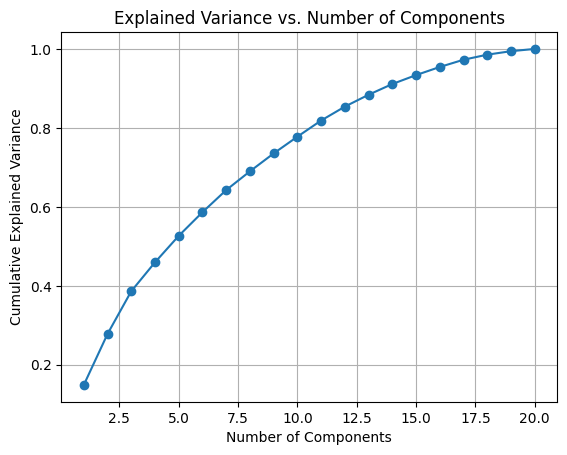

In [38]:
# GWR PCA Test

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("normalised_train.csv")
test_data = pd.read_csv("normalised_test.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [ # town_TE,flat_type_TE,flat_model_TE
    "month", "year", 
    "town_TE",
    "flat_type_TE",
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_TE",
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Remove NaNs/Infs from dataset to prevent errors
print("Ensuring all features are numeric and removing NaNs/Infs...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Drop rows with NaNs/Infs
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Standardise features before PCA
print("Standardising data before PCA...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardise coordinates to avoid scale mismatch
coords_train = StandardScaler().fit_transform(coords_train)
coords_test = StandardScaler().fit_transform(coords_test)

pca_full = PCA().fit(X_train)
explained_variance = np.cumsum(pca_full.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# # Apply PCA
# pca = PCA(n_components=0.90)  
# X_train_pca = pca.fit_transform(X_train)
# X_test_pca = pca.transform(X_test)

In [ ]:
# GWR PCA - Fixed for Numerical Stability Issues

import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("target_encoded_train.csv").sample(50000, random_state=42)
test_data = pd.read_csv("target_encoded_test.csv").sample(10000, random_state=42)

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [ # town_TE,flat_type_TE,flat_model_TE
    "month", "year", 
    "town_TE",
    "flat_type_TE",
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_TE",
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Remove NaNs/Infs from dataset to prevent errors
print("Ensuring all features are numeric and removing NaNs/Infs...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Drop rows with NaNs/Infs
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Extract feature matrix and coordinates
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values
X_train = train_data[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values
X_test = test_data[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values

# Standardise features before PCA
print("Standardising data before PCA...")
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Standardise coordinates to avoid scale mismatch
coords_scaler = StandardScaler()
coords_train = coords_scaler.fit_transform(coords_train)
coords_test = coords_scaler.transform(coords_test)

# Apply PCA
pca = PCA(n_components=0.97)  
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")

kernel = 'gaussian'
fixed = False

try:
    # while True:
        # print("Selecting optimal bandwidth using cross-validation...")
        
        # sample_indices = np.random.choice(len(train_data), 10000, replace=False)

        # print(f"coords_train[sample_indices] shape: {coords_train[sample_indices].shape}")
        # print(f"Target variable shape: {train_data[target_variable].values[sample_indices].reshape(-1, 1).shape}")
        # print(f"X_train_pca[sample_indices] shape: {X_train_pca[sample_indices].shape}")

        # selector = Sel_BW(
        #     coords_train[sample_indices], 
        #     train_data[target_variable].values[sample_indices].reshape(-1, 1), 
        #     X_train_pca[sample_indices],
        #     kernel=kernel, 
        #     fixed=not adaptive
        # )
        
        # opt_bw = selector.search()
        # print(f"opt_bw: {opt_bw}")

        # # Ensure bandwidth is within reasonable limits
        # if not np.isnan(opt_bw) and not np.isinf(opt_bw) and opt_bw >= 1:
        #     break  # Valid bandwidth found

    opt_bw = 200

    print("Verifying input shapes before GWR...")
    print(f"coords_train shape: {coords_train.shape}")
    print(f"Target variable shape: {train_data[target_variable].values.reshape(-1, 1).shape}")
    print(f"X_train_pca shape: {X_train_pca.shape}")
    print(f"opt_bw: {opt_bw}")

    # Train the GWR model
    print("Training the GWR model...")
    gwr_model = GWR(
        coords_train, 
        train_data[target_variable].values.reshape(-1, 1), 
        X_train_pca, 
        bw=opt_bw, 
        kernel=kernel, 
        fixed=fixed
    )
    gwr_results = gwr_model.fit()
    print("GWR Model Fitted Successfully!")
    gwr_results.summary()

    # Generate predictions
    scale = gwr_results.scale
    residuals = gwr_results.resid_response
    print(f"Scale: {scale}")
    print(f"Residuals Shape: {residuals.shape}")

    y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals)

    # Evaluate performance
    mae = mean_absolute_error(test_data[target_variable], y_pred.predictions.flatten())
    mse = mean_squared_error(test_data[target_variable], y_pred.predictions.flatten())
    rmse = np.sqrt(mse)
    r2 = r2_score(test_data[target_variable], y_pred.predictions.flatten())
    mape = np.mean(np.abs((test_data[target_variable] - y_pred.predictions.flatten()) / test_data[target_variable])) * 100

    print(f"Kernal: {kernel}, fixed: {fixed}, opt_btw: {opt_bw} PCA Components: {X_train_pca.shape[1]}, PCA %:{sum(pca.explained_variance_ratio_):.2f} MAE: {mae}, MAPE: {mape}, MSE: {mse}, RMSE: {rmse}, R² Score: {r2}")

except Exception as e:
    print(f"Error: {str(e)}")


Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric and removing NaNs/Infs...
Standardising data before PCA...
NaNs in coords_train before PCA: 0
Infs in coords_train before PCA: 0
Number of Principal Components Selected: 15
Explained Variance: 0.96
NaNs in target variable: 0
Infs in target variable: 0
NaNs in coords_train: 0
Infs in coords_train: 0
NaNs in X_train_pca: 0
Infs in X_train_pca: 0
Feature variances: [2.94189989 2.58037403 1.82190014 1.35468529 1.19397125 1.11616013
 0.95482063 0.90347216 0.85890479 0.82949671 0.69564658 0.60028379
 0.53781668 0.45452066 0.41013101]
Max value in X_train_pca: 7.854478045080538
Min value in X_train_pca: -5.703988278935523
Max value in coords_train: 34.28051939339353
Min value in coords_train: -27.254183980427108
X_train_pca shape after removal: (50000, 15)
coords_train shape after removal: (50000, 2)
train_data shape after removal: (50000, 94)
Verifying 

In [ ]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load datasets
print("Loading datasets...")
train_data = pd.read_csv("target_encoded_train.csv")
test_data = pd.read_csv("target_encoded_test.csv")

target_variable = "resale_price"
model_columns = [ # town_TE,flat_type_TE,flat_model_TE
    "month", "year", 
    "town_TE",
    "flat_type_TE",
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_TE",
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers
print("Converting boolean columns...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Ensure numeric format and drop NaNs
print("Handling NaNs and infinite values...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')
train_data = train_data.replace([np.inf, -np.inf], np.nan).dropna()
test_data = test_data.replace([np.inf, -np.inf], np.nan).dropna()

# Reset index
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

# Split data into spatial clusters
num_regions = 10  # Adjust based on memory availability
print(f"Clustering data into {num_regions} spatial regions...")
kmeans = KMeans(n_clusters=num_regions, random_state=42, n_init=10)
train_data['region'] = kmeans.fit_predict(train_data[['Latitude', 'Longitude']])
test_data['region'] = kmeans.predict(test_data[['Latitude', 'Longitude']])

# Prepare to store results
all_predictions = []
all_actuals = []

# Process each region separately
for region in range(num_regions):
    print(f"Processing region {region + 1}/{num_regions}...")
    
    # Filter region data
    region_train = train_data[train_data['region'] == region]
    region_test = test_data[test_data['region'] == region]
    
    # if len(region_train) < 500:  # Skip very small regions
    #     print(f"Skipping region {region}, too few data points.")
    #     continue

    coords_train = region_train[['Longitude', 'Latitude']].values
    coords_test = region_test[['Longitude', 'Latitude']].values
    X_train = region_train[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values
    X_test = region_test[model_columns].drop(columns=["Latitude", "Longitude"], errors='ignore').values
    y_train = region_train[target_variable].values.reshape(-1, 1)
    y_test = region_test[target_variable].values
    
    # Standardisation
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # PCA to reduce dimensions
    pca = PCA(n_components=0.90, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
    print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")
    
    print(f"Region {region}: {len(coords_train)} samples remaining after cleaning.")
    
    if len(coords_train) < 10:
        print(f"Skipping region {region}, too few valid data points after cleaning.")
        continue
    
    
    # kernels = ['gaussian', 'bisquare', 'exponential']
    # adaptive_options = [True, False]

    kernel = 'exponential'
    fixed = True
    opt_bw=200

    # Train GWR model
    try:
        print("Verifying input shapes before GWR...")
        print(f"coords_train shape: {coords_train.shape}")
        print(f"Target variable shape: {y_train.shape}")
        print(f"X_train_pca shape: {X_train_pca.shape}")
        print(f"opt_bw: {opt_bw}")

        gwr_model = GWR(coords_train, y_train, X_train_pca, bw=200, kernel=kernel, fixed=fixed)
        gwr_results = gwr_model.fit()
        print("GWR Model Fitted Successfully!")
        # gwr_results.summary()
        
        # Predict on test data
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals).predictions.flatten()
        
        all_predictions.extend(y_pred)
        all_actuals.extend(y_test)
        
    except Exception as e:
        print(f"Error in region {region}: {str(e)}")
        continue

# Evaluate overall performance
mae = mean_absolute_error(all_actuals, all_predictions)
mse = mean_squared_error(all_actuals, all_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(all_actuals, all_predictions)
mape = np.mean(np.abs((np.array(all_actuals) - np.array(all_predictions)) / np.array(all_actuals))) * 100

print(f"kernal: {kernel}, fixed: {fixed}, opt_btw: {opt_bw}, MAE: {mae}, MAPE: {mape}, MSE: {mse}, RMSE: {rmse}, R² Score: {r2}")


Loading datasets...
Converting boolean columns...
Handling NaNs and infinite values...
Clustering data into 100 spatial regions...
Processing region 1/100...
Number of Principal Components Selected: 9
Explained Variance: 0.91
Region 0: 7051 samples remaining after cleaning.
Verifying input shapes before GWR...
coords_train shape: (7051, 2)
Target variable shape: (7051, 1)
X_train_pca shape: (7051, 9)
opt_bw: 200
GWR Model Fitted Successfully!
Error in region 0: GWR.predict() got an unexpected keyword argument 'fixed'
Processing region 2/100...
Number of Principal Components Selected: 5
Explained Variance: 0.97
Region 1: 200 samples remaining after cleaning.
Verifying input shapes before GWR...
coords_train shape: (200, 2)
Target variable shape: (200, 1)
X_train_pca shape: (200, 5)
opt_bw: 200
GWR Model Fitted Successfully!
Error in region 1: GWR.predict() got an unexpected keyword argument 'fixed'
Processing region 3/100...
Number of Principal Components Selected: 9
Explained Variance:

In [9]:
# Check if any NaNs/Infs exist before running GWR
print(f"Checking for NaNs/Infs before fitting GWR in region {region}...")

print("NaNs in coords_train:", np.isnan(coords_train).sum())
print("Infs in coords_train:", np.isinf(coords_train).sum())

print("NaNs in X_train_pca:", np.isnan(X_train_pca).sum())
print("Infs in X_train_pca:", np.isinf(X_train_pca).sum())

print("NaNs in y_train:", np.isnan(y_train).sum())
print("Infs in y_train:", np.isinf(y_train).sum())


Checking for NaNs/Infs before fitting GWR in region 3...
NaNs in coords_train: 0
Infs in coords_train: 0
NaNs in X_train_pca: 0
Infs in X_train_pca: 0
NaNs in y_train: 0
Infs in y_train: 0


In [4]:
import folium
import pandas as pd
from folium.plugins import MarkerCluster

# Load dataset
df = pd.read_csv("target_encoded_test.csv")

# Remove missing values
df = df.dropna(subset=["Latitude", "Longitude", "resale_price"])

# Group by location and compute average resale price and count of transactions
grouped = df.groupby(["Latitude", "Longitude"], as_index=False).agg(
    avg_price=("resale_price", "mean"), count=("resale_price", "count")
)

# Create a map centered on Singapore
singapore_map_cluster = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Get the correct map variable name assigned by Folium
map_var_name = singapore_map_cluster.get_name()

# Create a marker cluster
marker_cluster = MarkerCluster().add_to(singapore_map_cluster)

# Add markers to the cluster
for _, row in grouped.iterrows():
    folium.Marker(
        location=[row["Latitude"], row["Longitude"]],
        popup=f"Avg Resale Price: ${row['avg_price']:,.2f} ({int(row['count'])} units)",
        tooltip=f"Avg Resale Price: ${row['avg_price']:,.2f} ({int(row['count'])} units)",
        icon=folium.Icon(color="blue", icon="info-sign"),
    ).add_to(marker_cluster)

# JavaScript for adding cluster hover tooltips
custom_js = f'''
<script>
document.addEventListener("DOMContentLoaded", function() {{
    var actualMap = { map_var_name };  // Correct map variable

    actualMap.eachLayer(function(layer) {{
        if (layer instanceof L.MarkerClusterGroup) {{
            console.log("Cluster layer detected!");  // Debugging

            layer.on("clustermouseover", function(e) {{
                console.log("Hover event fired!!!", e.layer);

                var cluster = e.layer;
                var totalPrice = 0;
                var totalCount = 0;

                // Recursively get only clustered markers
                function getMarkersInCluster(clusterLayer) {{
                    var markers = clusterLayer._markers || [];  // Directly inside this cluster

                    if (clusterLayer._childClusters && clusterLayer._childClusters.length > 0) {{
                        clusterLayer._childClusters.forEach(childCluster => {{
                            markers = markers.concat(getMarkersInCluster(childCluster)); // Collect markers from child clusters
                        }});
                    }}

                    return markers;
                }}

                var clusterMarkers = getMarkersInCluster(cluster);
                console.log("Total Cluster Markers Found:", clusterMarkers.length);

                // Separate pin markers (standalone markers outside clusters)
                var pinMarkers = [];
                actualMap.eachLayer(function(layer) {{
                    if (layer instanceof L.Marker && !layer.__parent) {{  // Exclude cluster markers
                        pinMarkers.push(layer);
                    }}
                }});

                // Merge both cluster markers and pin markers
                var allMarkers = clusterMarkers.concat(pinMarkers);
                console.log("Total Markers to Process:", allMarkers.length);

                if (allMarkers.length === 0) {{
                    console.warn("No visible markers found, skipping popup.");
                    return;
                }}

                // Debug: Check marker popups
                allMarkers.forEach(marker => {{
                    console.log("Checking marker:", marker);
                    console.log("Popup content:", marker.getPopup() ? marker.getPopup().getContent() : "No popup found");
                }});

                // Convert popup content to plain text (strip HTML tags if needed)
                function extractTextFromPopup(popupContent) {{
                    if (typeof popupContent === "string") {{
                        return popupContent.trim(); // Already plain text, trim spaces
                    }} else if (popupContent instanceof HTMLElement) {{
                        return (popupContent.textContent || popupContent.innerText || "").trim(); // Extract text from HTML element
                    }} else {{
                        console.warn("Unexpected popup content type:", popupContent);
                        return "";
                    }}
                }}

                // Process each marker to compute the avg resale price
                var validMarkers = allMarkers.filter(marker => marker instanceof L.Marker && marker.getPopup());

                if (validMarkers.length === 0) {{
                    console.warn("No valid resale price markers found, skipping popup.");
                    return;
                }}

                validMarkers.forEach(marker => {{
                    var popup = marker.getPopup();
                    if (popup) {{
                        var popupText = extractTextFromPopup(popup.getContent()); // Fix: Properly extract text

                        if (typeof popupText === "string") {{
                            var match = popupText.match(/\\$([\\d,]+\\.?\d{{0,2}})/);
                            var countMatch = popupText.match(/\\((\\d+\\.?\\d*) units\\)/);

                            if (match && countMatch) {{
                                var price = parseFloat(match[1].replace(/,/g, "")) || 0;
                                var count = parseFloat(countMatch[1]) || 0;

                                if (!isNaN(price) && !isNaN(count) && count > 0) {{
                                    totalPrice += price * count;
                                    totalCount += count;
                                }} else {{
                                    console.warn("Skipping invalid price/count values:", price, count);
                                }}
                            }}
                        }}
                    }}
                }});

                if (totalCount > 0) {{
                    var avgPrice = (totalPrice / totalCount).toFixed(2);
                    
                    // Format totalCount: Remove `.0` if it's a whole number
                    var formattedTotalCount = (totalCount % 1 === 0) ? totalCount.toFixed(0) : totalCount.toFixed(2);

                    var popup = L.popup({{
                        closeButton: false,
                        autoClose: false,
                        closeOnClick: false,
                        className: "custom-cluster-tooltip"
                    }})
                    .setContent(
                        "<b>Avg Resale Price: $" + avgPrice + "</b><br>" +
                        "<b>Total Units: " + formattedTotalCount + "</b>"
                    )
                    .setLatLng(cluster.getLatLng());

                    popup.openOn(actualMap);

                    // **Immediate Popup Disappearance on Mouseout**
                    cluster.on("mouseout", function() {{
                        actualMap.closePopup();
                    }});
                }} else {{
                    console.warn("No valid resale prices found, popup not created.");
                }}
            }});
        }}
    }});
}});
</script>
'''

# Attach the custom JavaScript to the map
singapore_map_cluster.get_root().html.add_child(folium.Element(custom_js))

# Save and view
singapore_map_cluster.save("singapore_clustered_avg_hover.html")
print("Clustered resale price map with hover popups saved as singapore_clustered_avg_hover.html")


Clustered resale price map with hover popups saved as singapore_clustered_avg_hover.html


In [ ]:
import folium
import pandas as pd
from folium.plugins import HeatMap
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv("target_encoded_test.csv")

# Remove missing values
df = df.dropna(subset=["Latitude", "Longitude", "resale_price"])

# Normalize resale price to range [0.1, 1] to avoid zero intensity
scaler = MinMaxScaler(feature_range=(0.1, 1))
df["scaled_price"] = scaler.fit_transform(df[["resale_price"]])

# Create a map centered on Singapore
singapore_map_price = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Prepare data: [lat, lon, intensity]
heat_data_price = df[["Latitude", "Longitude", "scaled_price"]].values.tolist()

# Add HeatMap layer
HeatMap(heat_data_price, radius=12, blur=15, max_zoom=14).add_to(singapore_map_price)

# Save and view
singapore_map_price.save("singapore_resale_price_heatmap.html")
print("Resale price heatmap saved as singapore_resale_price_heatmap.html")

Resale price heatmap saved as singapore_resale_price_heatmap.html
Resale price heatmap saved as singapore_resale_price_heatmap.html


In [ ]:
import folium
import pandas as pd
from folium.plugins import HeatMap

# Load dataset
df = pd.read_csv("target_encoded_test.csv")

# Remove missing values
df = df.dropna(subset=["Latitude", "Longitude"])

# Create a map centered on Singapore
singapore_map_density = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# Prepare data: [lat, lon] (no weight)
heat_data_density = df[["Latitude", "Longitude"]].values.tolist()

# Add HeatMap layer (without weighting)
HeatMap(heat_data_density, radius=12, blur=15, max_zoom=14).add_to(singapore_map_density)

# Save and view
singapore_map_density.save("singapore_density_heatmap.html")
print("Density heatmap saved as singapore_density_heatmap.html")


In [26]:
import numpy as np

# Function to check NaNs and Infs in arrays
def check_nans_infs(name, array):
    if np.any(np.isnan(array)):
        print(f"Warning: {name} contains NaNs!")
    if np.any(np.isinf(array)):
        print(f"Warning: {name} contains Infs!")

# Checking coords_train (longitude & latitude)
print("Checking coords_train...")
check_nans_infs("coords_train", coords_train)

# Checking target variable
print("Checking target variable (resale_price)...")
check_nans_infs("train_data[target_variable]", train_data[target_variable].values.reshape(-1, 1))

# Checking X_train_pca (PCA-transformed features)
print("Checking X_train_pca...")
check_nans_infs("X_train_pca", X_train_pca)

# Checking bandwidth selection value
if np.isnan(opt_bw) or np.isinf(opt_bw):
    print("Warning: opt_bw contains NaN or Inf!")

print("----------------------------------------")

print("Checking for extreme values in data...")

# Check coordinates
print(f"Longitude range: {coords_train[:, 0].min()} to {coords_train[:, 0].max()}")
print(f"Latitude range: {coords_train[:, 1].min()} to {coords_train[:, 1].max()}")

# Check PCA-transformed features
print(f"X_train_pca min: {X_train_pca.min()}, max: {X_train_pca.max()}")
print(f"X_test_pca min: {X_test_pca.min()}, max: {X_test_pca.max()}")

# Check target variable
print(f"Target variable min: {train_data[target_variable].min()}, max: {train_data[target_variable].max()}")



Checking coords_train...
Checking target variable (resale_price)...
Checking X_train_pca...
----------------------------------------
Checking for extreme values in data...
Longitude range: 0.0 to 0.9999335674604416
Latitude range: 0.0 to 1.0
X_train_pca min: -44.949677061239676, max: 91.05383911922348
X_test_pca min: -31.838691868628906, max: 77.15761195280511
Target variable min: 0.0068493150684931, max: 0.9863013698630138



GUASSIAN
Mean Absolute Error (MAE): 0.07886822348806316
Mean Squared Error (MSE): 0.010459145242201446
Root Mean Squared Error (RMSE): 0.10226996256086851
R² Score: 0.3386578854628215

BISQUARE
Mean Absolute Error (MAE): 0.07549681841499624
Mean Squared Error (MSE): 0.00996194775705299
Root Mean Squared Error (RMSE): 0.09980955744342819
R² Score: 0.3700961749746552

EXPONENTIAL
Mean Absolute Error (MAE): 0.07836792864710952
Mean Squared Error (MSE): 0.010350346436098199
Root Mean Squared Error (RMSE): 0.1017366523731649
R² Score: 0.34553734174927964

In [1]:
import numpy as np
import pandas as pd
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.decomposition import PCA
from itertools import product
import dask
from dask.distributed import Client

# Initialize Dask client for parallel processing
client = Client()

# Load new datasets
print("Loading new datasets...")
train_data = pd.read_csv("../../Data/normalized_test.csv")
test_data = pd.read_csv("../../Data/normalized_train.csv")

# Define target variable and features
print("Defining target variable and features...")
target_variable = "resale_price"
model_columns = [
    "month", "year", 
    "town_YISHUN", "town_WOODLANDS", "town_TOA PAYOH", "town_TAMPINES", "town_SERANGOON", "town_SENGKANG", "town_SEMBAWANG", "town_QUEENSTOWN", "town_PUNGGOL", "town_PASIR RIS", 
    "town_MARINE PARADE", "town_KALLANG/WHAMPOA", "town_JURONG WEST", "town_JURONG EAST", "town_HOUGANG", "town_GEYLANG", "town_CLEMENTI", "town_CHOA CHU KANG", "town_CENTRAL AREA", 
    "town_BUKIT TIMAH", "town_BUKIT PANJANG", "town_BUKIT MERAH", "town_BUKIT BATOK", "town_BISHAN", "town_BEDOK", 
    "flat_type_MULTI-GENERATION", "flat_type_EXECUTIVE", "flat_type_5 ROOM", "flat_type_4 ROOM", "flat_type_3 ROOM", "flat_type_2 ROOM", 
    "storey_range_LE", 
    "price_per_sqm", 
    "flat_model_Type S2", "flat_model_Type S1", "flat_model_Terrace", "flat_model_Standard", "flat_model_Simplified", "flat_model_Premium Maisonette", "flat_model_Premium Apartment Loft", 
    "flat_model_Premium Apartment", "flat_model_New Generation", "flat_model_Multi Generation", "flat_model_Model A2", "flat_model_Model A-Maisonette", "flat_model_Model A", 
    "flat_model_Maisonette", "flat_model_Improved-Maisonette", "flat_model_Improved", "flat_model_DBSS", "flat_model_Apartment", "flat_model_Adjoined flat", "flat_model_3Gen", 
    "lease_commence_date",
    "Latitude", "Longitude", 
    "LTAMRTStation_within_1km",
    "MallCoordinates_within_1km", "Hawker_within_1km", 
    "PreSchool_within_1km", "Primary_within_1km", "Secondary_within_1km", 
    "JuniorCollege_within_1km","MixedLevel_within_1km", 
    "NParks_within_1km", "Sports_within_1km", 
]

# Convert boolean columns to integers (0 or 1)
print("Converting boolean columns to integers...")
bool_cols = train_data.select_dtypes(include=['bool']).columns
train_data[bool_cols] = train_data[bool_cols].astype(int)
test_data[bool_cols] = test_data[bool_cols].astype(int)

# Convert all features and target variable to numeric
print("Ensuring all features are numeric...")
train_data[model_columns] = train_data[model_columns].apply(pd.to_numeric, errors='coerce')
test_data[model_columns] = test_data[model_columns].apply(pd.to_numeric, errors='coerce')
train_data[target_variable] = pd.to_numeric(train_data[target_variable], errors='coerce')
test_data[target_variable] = pd.to_numeric(test_data[target_variable], errors='coerce')

# Extract feature matrix and coordinates
X_train = train_data[model_columns].values
X_test = test_data[model_columns].values
coords_train = train_data[['Longitude', 'Latitude']].values
coords_test = test_data[['Longitude', 'Latitude']].values

# Apply PCA to retain 97% variance
print("Applying PCA for 0.97 variance...")
pca = PCA(n_components=0.97)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

print(f"Number of Principal Components Selected: {X_train_pca.shape[1]}")
print(f"Explained Variance: {sum(pca.explained_variance_ratio_):.2f}")


# kernels = ['gaussian', 'bisquare', 'exponential']
# adaptive_options = [True, False]

# Define hyperparameter grid
kernels = ['gaussian']
adaptive_options = [False]

print("Traning and Evaluation...")
# Function to train and evaluate a GWR model
@dask.delayed
def train_gwr(kernel, adaptive):
    print(f"Testing kernel: {kernel}, Adaptive: {adaptive}", flush=True)
    try:
        # selector = Sel_BW(coords_train, train_data[target_variable].values.reshape(-1, 1), X_train_pca, kernel=kernel, fixed=not adaptive)
        
        # Randomly select sample_size rows for bandwidth selection
        sample_indices = np.random.choice(len(train_data), 5000, replace=False)

        selector = Sel_BW(
            coords_train[sample_indices], 
            train_data[target_variable].values[sample_indices].reshape(-1, 1), 
            X_train_pca[sample_indices],
            kernel=kernel, 
            fixed=not adaptive
        )
        
        opt_bw = selector.search()
        
        print("Fitting the GWR model...", flush=True)
        gwr_model = GWR(coords_train, train_data[target_variable].values.reshape(-1, 1), X_train_pca, bw=opt_bw, kernel=kernel, fixed=not adaptive)
        gwr_results = gwr_model.fit()
        print("GWR Model Fitted Successfully!", flush=True)
        gwr_results.summary()
        
        # Generate predictions correctly
        scale = gwr_results.scale
        residuals = gwr_results.resid_response
        y_pred = gwr_model.predict(coords_test, X_test_pca, scale, residuals)
        
        mae = mean_absolute_error(test_data[target_variable], y_pred.predictions.flatten())
        mse = mean_squared_error(test_data[target_variable], y_pred.predictions.flatten())
        rmse = np.sqrt(mse)
        r2 = r2_score(test_data[target_variable], y_pred.predictions.flatten())
        mape = np.mean(np.abs((test_data[target_variable] - y_pred.predictions.flatten()) / test_data[target_variable])) * 100
        aic = gwr_results.aic
    except Exception as e:
        print(f"Error occurred with kernel: {kernel}, Adaptive: {adaptive}: {str(e)}", flush=True)
        opt_bw, mae, mse, rmse, r2, mape, aic = -1, -1, -1, -1, -1, -1, -1
    
    return {
        "Kernel": kernel,
        "Adaptive": adaptive,
        "Bandwidth": opt_bw,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R²": r2,
        "MAPE": mape,
        "AIC": aic
    }

# Parallel grid search using Dask
results = dask.compute(*[train_gwr(kernel, adaptive) for kernel, adaptive in product(kernels, adaptive_options)])

# Save results to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("gwr_results_1.csv", index=False)

# Identify best model based on AIC
best_result = min(results, key=lambda x: x["AIC"])
print(f"Best Kernel: {best_result['Kernel']}, Adaptive: {best_result['Adaptive']}, Optimal Bandwidth: {best_result['Bandwidth']}")
print(f"Best AIC Score: {best_result['AIC']}")

# Shutdown the Dask client to free resources
client.shutdown()

Loading new datasets...
Defining target variable and features...
Converting boolean columns to integers...
Ensuring all features are numeric...
Applying PCA for 0.97 variance...
Number of Principal Components Selected: 7
Explained Variance: 0.98
Traning and Evaluation...


c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\client.py:3370: UserWarning: Sending large graph of size 234.50 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
2025-03-12 21:27:24,786 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62905 (pid=26208) exceeded 95% memory budget. Restarting...
2025-03-12 21:27:25,218 - distributed.nanny - WARNING - Restarting worker
2025-03-12 21:37:53,251 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62911 (pid=9172) exceeded 95% memory budget. Restarting...
2025-03-12 21:37:53,687 - distributed.nanny - WARNING - Restarting worker
2025-03-12 21:48:12,291 - distributed.nanny.memory - WARNING - Worker tcp://127.0.0.1:62994 (pid=2744) exceeded 95% memory

KilledWorker: Attempted to run task 'train_gwr-feb4f99e-4787-4d0f-b764-e5f7a2b31f2b' on 4 different workers, but all those workers died while running it. The last worker that attempt to run the task was tcp://127.0.0.1:62906. Inspecting worker logs is often a good next step to diagnose what went wrong. For more information see https://distributed.dask.org/en/stable/killed.html.